In [4]:
from mxnet import nd
from mxnet.gluon import nn

In [5]:
layer = nn.Dense(2)
layer

Dense(None -> 2, linear)

In [6]:
layer.initialize()

In [7]:
x = nd.random.uniform(-1,1,(3,4))
layer(x)

layer.weight.data()


[[-0.00873779 -0.02834515  0.05484822 -0.06206018]
 [ 0.06491279 -0.03182812 -0.01631819 -0.00312688]]
<NDArray 2x4 @cpu(0)>

In [8]:
net = nn.Sequential()
# Add a sequence of layers.
net.add(# Similar to Dense, it is not necessary to specify the input channels
        # by the argument `in_channels`, which will be  automatically inferred
        # in the first forward pass. Also, we apply a relu activation on the
        # output. In addition, we can use a tuple to specify a  non-square
        # kernel size, such as `kernel_size=(2,4)`
        nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        # One can also use a tuple to specify non-symmetric pool and stride sizes
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        # The dense layer will automatically reshape the 4-D output of last
        # max pooling layer into the 2-D shape: (x.shape[0], x.size/x.shape[0])
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10))
net

Sequential(
  (0): Conv2D(None -> 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (2): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (4): Dense(None -> 120, Activation(relu))
  (5): Dense(None -> 84, Activation(relu))
  (6): Dense(None -> 10, linear)
)

In [9]:
net.initialize()
# Input shape is (batch_size, color_channels, height, width)
x = nd.random.uniform(shape=(4,1,28,28))
y = net(x)
y.shape

(4, 10)

In [10]:
(net[0].weight.data().shape, net[5].bias.data().shape)

((6, 1, 5, 5), (84,))

In [11]:
class MixMLP(nn.Block):
    def __init__(self, **kwargs):
        # Run `nn.Block`'s init method
        super(MixMLP, self).__init__(**kwargs)
        self.blk = nn.Sequential()
        self.blk.add(nn.Dense(3, activation='relu'),
                     nn.Dense(4, activation='relu'))
        self.dense = nn.Dense(5)
    def forward(self, x):
        y = nd.relu(self.blk(x))
        print(y)
        return self.dense(y)

net = MixMLP()
net

MixMLP(
  (blk): Sequential(
    (0): Dense(None -> 3, Activation(relu))
    (1): Dense(None -> 4, Activation(relu))
  )
  (dense): Dense(None -> 5, linear)
)

In [12]:
net.initialize()
x = nd.random.uniform(shape=(2,2))
net(x)


[[0.0000000e+00 0.0000000e+00 6.2900386e-04 7.6445540e-05]
 [0.0000000e+00 0.0000000e+00 1.1989386e-03 1.2375204e-03]]
<NDArray 2x4 @cpu(0)>



[[-3.8061840e-05  1.5568350e-05  4.3668215e-06  4.2853058e-05
   1.8710394e-05]
 [-1.8345519e-05  2.6403079e-05  2.4685731e-05  7.7019373e-05
   9.7785989e-05]]
<NDArray 2x5 @cpu(0)>

In [13]:
net.blk[1].weight.data()


[[-0.0343901  -0.05805862 -0.06187592]
 [-0.06210143 -0.00918167 -0.00170272]
 [-0.02634858  0.05334064  0.02748809]
 [ 0.06669661 -0.01711474  0.01647211]]
<NDArray 4x3 @cpu(0)>

In [14]:
from mxnet import nd
from mxnet import autograd

x = nd.array([[1, 2], [3, 4]])
x.attach_grad()

with autograd.record():
    y = 2 * x * x
    
y.backward()
x.grad


[[ 4.  8.]
 [12. 16.]]
<NDArray 2x2 @cpu(0)>

In [15]:
from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
from IPython import display
import matplotlib.pyplot as plt
import time

In [16]:
mnist_train = datasets.FashionMNIST(train=True)
X, y = mnist_train[0]
('X shape: ', X.shape, 'X dtype', X.dtype, 'y:', y)

('X shape: ', (28, 28, 1), 'X dtype', numpy.uint8, 'y:', 2)

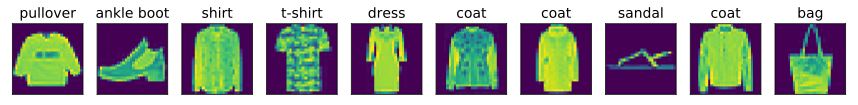

In [17]:
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
X, y = mnist_train[0:10]
# plot images
display.set_matplotlib_formats('svg')
_, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
for f,x,yi in zip(figs, X,y):
    # 3D->2D by removing the last channel dim
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])
mnist_train = mnist_train.transform_first(transformer)

In [21]:
batch_size = 256
train_data = gluon.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)

In [22]:
for data, label in train_data:
    print(data.shape, label.shape)
    break

(256, 1, 28, 28) (256,)


In [30]:
mnist_valid = gluon.data.vision.FashionMNIST(train=False)
valid_data = gluon.data.DataLoader(
    mnist_valid.transform_first(transformer),
    batch_size=batch_size, num_workers=0)

In [24]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10))
net.initialize(init=init.Xavier())

In [25]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [26]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [28]:
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) ==
            label.astype('float32')).mean().asscalar()

In [31]:
for epoch in range(10):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time.time()
    for data, label in train_data:
        # forward + backward
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        # update parameters
        trainer.step(batch_size)
        # calculate training metrics
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label)
    # calculate validation accuracy
    for data, label in valid_data:
        valid_acc += acc(net(data), label)
    print("Epoch %d: loss %.3f, train acc %.3f, test acc %.3f, in %.1f sec" % (
            epoch, train_loss/len(train_data), train_acc/len(train_data),
            valid_acc/len(valid_data), time.time()-tic))

Epoch 0: loss 0.459, train acc 0.831, test acc 0.851, in 34.0 sec


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\queues.py", line 236, in _feed
    send_bytes(obj)
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 280, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
OSError: [WinError 6] ハンドルが無効です。
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\queues.py", line 236, in _feed
    send_bytes(obj)
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 280, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
OSError: [WinError 6] ハンドルが無効です。


Epoch 1: loss 0.398, train acc 0.854, test acc 0.873, in 34.3 sec


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\queues.py", line 230, in _feed
    close()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] ハンドルが無効です。


Epoch 2: loss 0.359, train acc 0.868, test acc 0.878, in 31.3 sec
Epoch 3: loss 0.334, train acc 0.875, test acc 0.878, in 30.6 sec
Epoch 4: loss 0.316, train acc 0.885, test acc 0.889, in 31.2 sec
Epoch 5: loss 0.302, train acc 0.889, test acc 0.891, in 36.5 sec
Epoch 6: loss 0.290, train acc 0.894, test acc 0.895, in 42.1 sec
Epoch 7: loss 0.280, train acc 0.897, test acc 0.893, in 45.4 sec
Epoch 8: loss 0.269, train acc 0.900, test acc 0.899, in 44.8 sec
Epoch 9: loss 0.263, train acc 0.902, test acc 0.902, in 43.5 sec


In [32]:
net.save_parameters('net.params')

In [33]:
from mxnet.gluon.model_zoo import vision as models
from mxnet.gluon.utils import download
from mxnet import image

net = models.resnet50_v2(pretrained=True)

In [34]:
url = 'http://data.mxnet.io/models/imagenet/synset.txt'
fname = download(url)
with open(fname, 'r') as f:
    text_labels = [' '.join(l.split()[1:]) for l in f]

In [35]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/\
Golden_Retriever_medium-to-light-coat.jpg/\
365px-Golden_Retriever_medium-to-light-coat.jpg'
fname = download(url)
x = image.imread(fname)

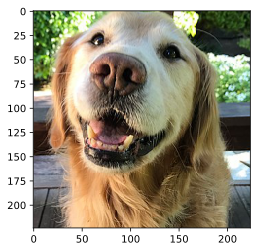

In [36]:
x = image.resize_short(x, 256)
x, _ = image.center_crop(x, (224,224))
plt.imshow(x.asnumpy())
plt.show()

In [37]:
def transform(data):
    data = data.transpose((2,0,1)).expand_dims(axis=0)
    rgb_mean = nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1))
    rgb_std = nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1))
    return (data.astype('float32') / 255 - rgb_mean) / rgb_std

In [38]:
prob = net(transform(x)).softmax()
idx = prob.topk(k=5)[0]
for i in idx:
    i = int(i.asscalar())
    print('With prob = %.5f, it contains %s' % (
        prob[0,i].asscalar(), text_labels[i]))

With prob = 0.98240, it contains golden retriever
With prob = 0.00809, it contains English setter
With prob = 0.00262, it contains Irish setter, red setter
With prob = 0.00223, it contains cocker spaniel, English cocker spaniel, cocker
With prob = 0.00177, it contains Labrador retriever
